# Cholesky Experiment Results Visualization

This notebook visualizes the build metrics and runtime performance results from the cholesky decomposition experiment.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Load Data

In [24]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

def get_latest_file(pattern):
    """Get the most recent file matching the pattern."""
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No files found for pattern: {pattern}")
    return max(files, key=os.path.getmtime)

# Create images directory if it doesn't exist
images_dir = Path('images')
images_dir.mkdir(exist_ok=True)

# Load the most recent build_metrics and results files from subdirectories
build_metrics_file = get_latest_file('build_metrics/build_metrics_*.csv')
results_file = get_latest_file('results/results_*.csv')

build_metrics = pd.read_csv(build_metrics_file)
results = pd.read_csv(results_file)

# Parse config_name to extract components for build_metrics
build_metrics[['matrix_size', 'num_blocks', 'scheduler']] = build_metrics['config_name'].str.split('_', expand=True)
build_metrics['matrix_size'] = build_metrics['matrix_size'].astype(int)
build_metrics['num_blocks'] = build_metrics['num_blocks'].astype(int)

# results.csv already has the columns split, no need to parse config_name

# Check available columns
has_compile_time = 'compile_time' in build_metrics.columns

print(f"Loaded build metrics from: {build_metrics_file}")
print(f"Loaded results from: {results_file}")
print("Build Metrics:")
print(build_metrics.head())
print("\nBuild Metrics columns:", build_metrics.columns.tolist())
print(f"Has compile_time: {has_compile_time}")
print("\nRuntime Results:")
print(results.head())
print("\nRuntime Results columns:", results.columns.tolist())

Loaded build metrics from: build_metrics/build_metrics_20251118_023539.csv
Loaded results from: results/results_20251118_023539.csv
Build Metrics:
          config_name  text_size  data_size  bss_size  total_size  \
0  10080_1_sequential       1015          0         8        8032   
1    10080_1_omp-task       1244          0         8        8680   
2  10080_2_sequential       1280         40         8        8504   
3    10080_2_omp-task       1860         40         8        9504   
4  10080_4_sequential       1611         56         8        8912   

   compile_time  matrix_size  num_blocks   scheduler  
0      0.588815        10080           1  sequential  
1      0.576238        10080           1    omp-task  
2      0.611994        10080           2  sequential  
3      0.600627        10080           2    omp-task  
4      0.633377        10080           4  sequential  

Build Metrics columns: ['config_name', 'text_size', 'data_size', 'bss_size', 'total_size', 'compile_time', 

## Binary Size Analysis - Relative to Sequential (% Change)

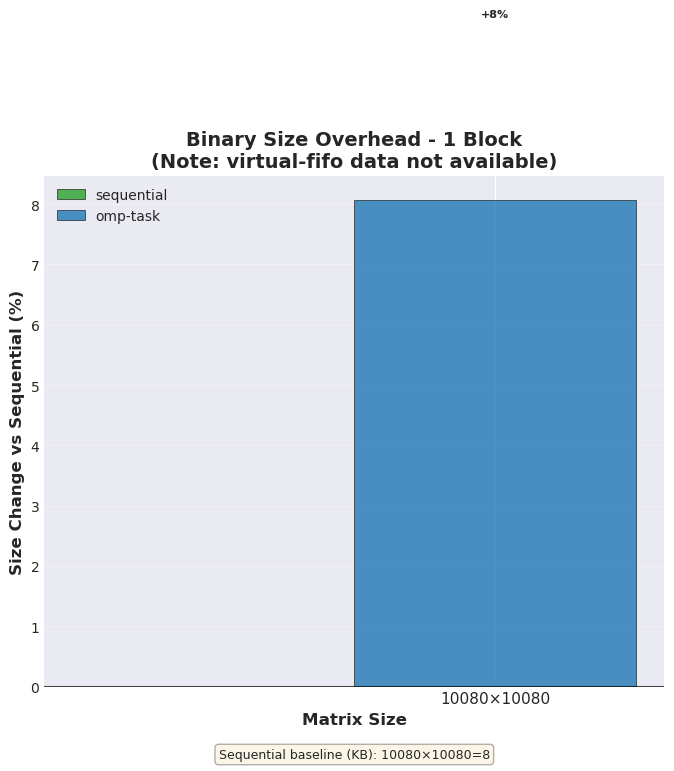

Saved: images/binary_size_overhead_1blocks.png


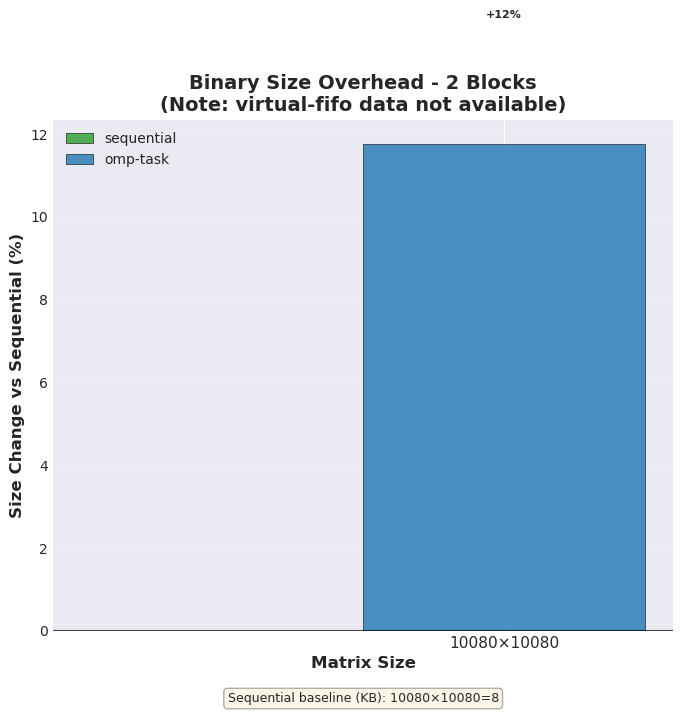

Saved: images/binary_size_overhead_2blocks.png


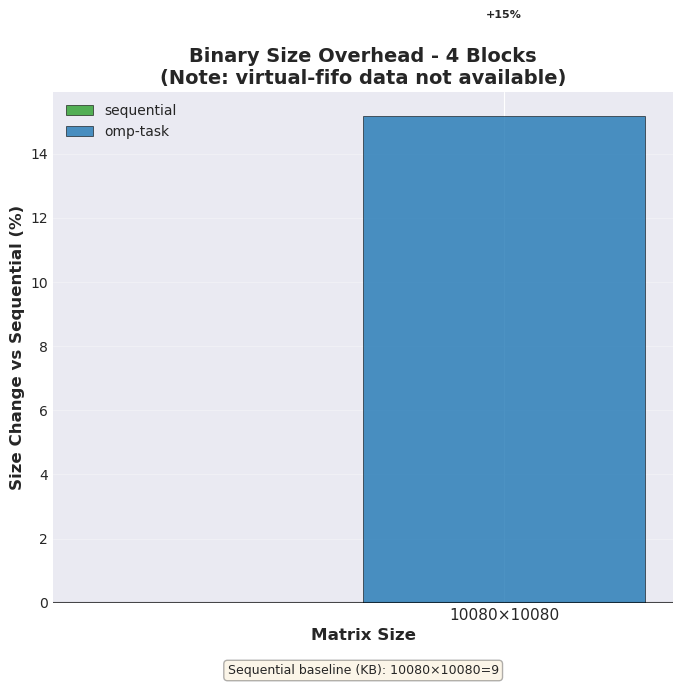

Saved: images/binary_size_overhead_4blocks.png


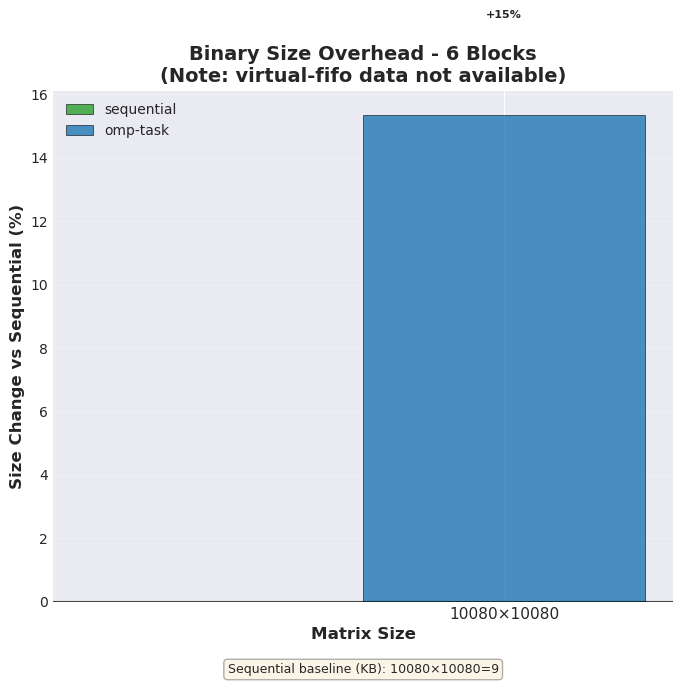

Saved: images/binary_size_overhead_6blocks.png


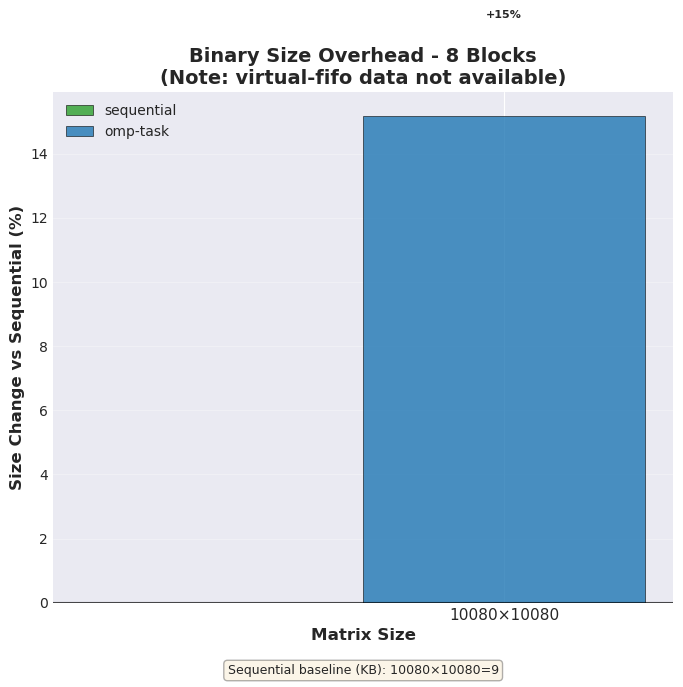

Saved: images/binary_size_overhead_8blocks.png


In [25]:
# Define scheduler order and colors
scheduler_order = ['sequential', 'omp-task', 'virtual-fifo']
scheduler_colors = {'sequential': '#2ca02c', 'omp-task': '#1f77b4', 'virtual-fifo': '#ff7f0e'}

# Get unique number of blocks
num_blocks_list = sorted(build_metrics['num_blocks'].unique())

# Create one graph for each num_blocks configuration
for num_blocks in num_blocks_list:
    # Adjust figure size based on number of matrix sizes
    blocks_data = build_metrics[build_metrics['num_blocks'] == num_blocks].copy()
    matrix_sizes = sorted(blocks_data['matrix_size'].unique())
    num_groups = len(matrix_sizes)
    
    # Skip if no data
    if num_groups == 0:
        print(f"No data for {num_blocks} blocks, skipping...")
        continue
    
    # Set figure width: min 8, max 16, scale with number of groups
    fig_width = min(max(8, num_groups * 3), 16)
    fig, ax = plt.subplots(figsize=(fig_width, 7))
    
    # Calculate positions for grouped bars
    bar_width = 0.3
    group_width = len(scheduler_order) * bar_width + 0.2
    x_group_centers = np.arange(num_groups) * group_width
    
    # Track data for plotting
    scheduler_data = {sched: [] for sched in scheduler_order}
    sequential_values = []
    has_data = False
    schedulers_present = set()
    
    # For each matrix size configuration
    for matrix_size in matrix_sizes:
        # Get sequential baseline
        seq_data = blocks_data[
            (blocks_data['matrix_size'] == matrix_size) & 
            (blocks_data['scheduler'] == 'sequential')
        ]
        
        if len(seq_data) > 0:
            seq_size = seq_data.iloc[0]['total_size']
            sequential_values.append(seq_size / 1024)  # Store in KB for reference
            
            # For each scheduler
            for sched in scheduler_order:
                sched_data = blocks_data[
                    (blocks_data['matrix_size'] == matrix_size) & 
                    (blocks_data['scheduler'] == sched)
                ]
                
                if len(sched_data) > 0:
                    sched_size = sched_data.iloc[0]['total_size']
                    # Calculate percentage change relative to sequential
                    pct_change = ((sched_size - seq_size) / seq_size) * 100
                    scheduler_data[sched].append(pct_change)
                    has_data = True
                    schedulers_present.add(sched)
                else:
                    # Missing data for this scheduler - use NaN to skip plotting
                    scheduler_data[sched].append(np.nan)
        else:
            # No sequential baseline - skip this matrix size
            sequential_values.append(0)
            for sched in scheduler_order:
                scheduler_data[sched].append(np.nan)
    
    # Skip if no valid data
    if not has_data:
        print(f"No valid data for {num_blocks} blocks, skipping...")
        plt.close(fig)
        continue
    
    # Plot bars for each scheduler
    for sched_idx, sched in enumerate(scheduler_order):
        offset = (sched_idx - 1) * bar_width
        x_pos = x_group_centers + offset
        values = np.array(scheduler_data[sched])
        
        # Filter out NaN values for plotting
        valid_mask = ~np.isnan(values)
        if not valid_mask.any():
            continue  # Skip this scheduler if no valid data
        
        valid_x = x_pos[valid_mask]
        valid_values = values[valid_mask]
        
        bars = ax.bar(valid_x, valid_values, bar_width, label=sched, 
                     color=scheduler_colors[sched], alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for xp, val in zip(valid_x, valid_values):
            if abs(val) > 0.1:  # Only show label if not essentially zero
                y_pos = val + (3 if val >= 0 else -3)
                va = 'bottom' if val >= 0 else 'top'
                ax.text(xp, y_pos, f'{val:+.0f}%', ha='center', va=va, fontsize=8, fontweight='bold')
    
    # Add reference line at 0%
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    
    # Customize the plot
    ax.set_ylabel('Size Change vs Sequential (%)', fontweight='bold', fontsize=12)
    
    # Add note if some schedulers are missing
    missing_schedulers = set(scheduler_order) - schedulers_present
    title = f'Binary Size Overhead - {num_blocks} Block{"s" if num_blocks > 1 else ""}'
    if missing_schedulers:
        title += f'\n(Note: {", ".join(sorted(missing_schedulers))} data not available)'
    ax.set_title(title, fontweight='bold', fontsize=14)
    
    ax.set_xticks(x_group_centers)
    ax.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes], fontsize=11)
    ax.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='best', fontsize=10)
    
    # Add sequential baseline sizes as text below
    textstr = 'Sequential baseline (KB): ' + ', '.join([f'{ms}×{ms}={val:.0f}' 
                                                         for ms, val in zip(matrix_sizes, sequential_values) if val > 0])
    ax.text(0.5, -0.12, textstr, transform=ax.transAxes, fontsize=9, 
           verticalalignment='top', horizontalalignment='center',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Adjust layout with extra space at bottom for text box
    plt.subplots_adjust(bottom=0.15)
    filename = images_dir / f'binary_size_overhead_{num_blocks}blocks.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

## Binary Size Comparison - Overall View

Found 34 sections, ordered by total size:
  1. .relro_padding: 22.5 KB total
  2. .text: 17.5 KB total
  3. .dynstr: 5.6 KB total
  4. .dynsym: 5.6 KB total
  5. .dynamic: 5.5 KB total
  6. .rela.plt: 3.1 KB total
  7. .rodata.str1.1: 3.1 KB total
  8. .annobin.notes: 2.4 KB total
  9. .plt: 2.4 KB total
  10. .rela.dyn: 1.9 KB total


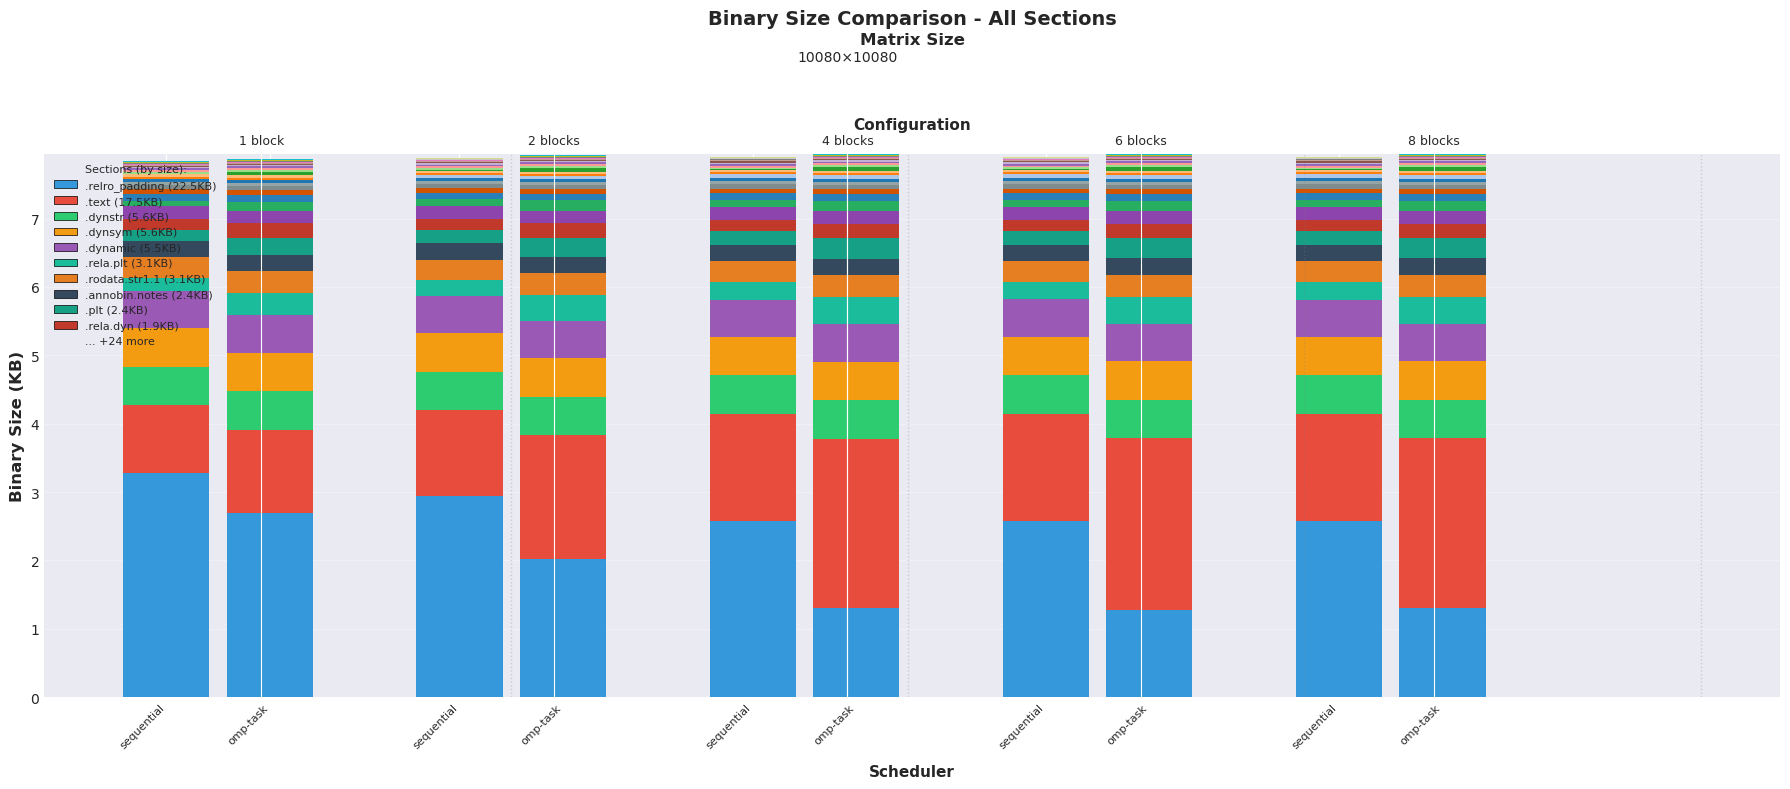

Saved: images/binary_size_grouped.png


In [26]:
# Overall binary size comparison by scheduler - reading directly from binaries
import subprocess
import re
from pathlib import Path

# Get binary paths for each configuration
def get_binary_path(matrix_size, num_blocks, scheduler):
    """Construct path to binary for a given configuration."""
    config_name = f"{matrix_size}_{num_blocks}_{scheduler}"
    return Path(f"instances/{config_name}/build/test/Iara/05-cholesky/build-{scheduler}/a.out")

def get_section_sizes(binary_path):
    """Run 'size -A' and parse all section sizes."""
    try:
        result = subprocess.run(['size', '-A', str(binary_path)], 
                              capture_output=True, text=True, check=True)
        lines = result.stdout.splitlines()
        section_sizes = {}
        for line in lines:
            m = re.match(r'\s*(\S+)\s+(\d+)', line)
            if m:
                section = m.group(1)
                size = int(m.group(2))
                if section not in ['section', 'Total']:  # Skip header and total
                    section_sizes[section] = size
        return section_sizes
    except Exception as e:
        print(f"Error reading {binary_path}: {e}")
        return {}

# Collect all section data
all_sections = set()
config_data = []

for _, row in build_metrics.iterrows():
    matrix_size = row['matrix_size']
    num_blocks = row['num_blocks']
    scheduler = row['scheduler']
    
    binary_path = get_binary_path(matrix_size, num_blocks, scheduler)
    if binary_path.exists():
        sections = get_section_sizes(binary_path)
        config_data.append({
            'matrix_size': matrix_size,
            'num_blocks': num_blocks,
            'scheduler': scheduler,
            'sections': sections
        })
        all_sections.update(sections.keys())
    else:
        print(f"Binary not found: {binary_path}")

# Calculate total size for each section across all binaries
section_totals = {}
for section in all_sections:
    total = sum(config['sections'].get(section, 0) for config in config_data)
    section_totals[section] = total

# Sort sections by total size (largest first)
sorted_sections = sorted(all_sections, key=lambda s: section_totals[s], reverse=True)

print(f"Found {len(sorted_sections)} sections, ordered by total size:")
for i, section in enumerate(sorted_sections[:10]):
    print(f"  {i+1}. {section}: {section_totals[section]/1024:.1f} KB total")

# Create data structure for plotting
import pandas as pd

# Build DataFrame with sections as columns
plot_data = []
for config in config_data:
    row_data = {
        'matrix_size': config['matrix_size'],
        'num_blocks': config['num_blocks'],
        'scheduler': config['scheduler']
    }
    for section in sorted_sections:
        row_data[section] = config['sections'].get(section, 0) / 1024  # Convert to KB
    plot_data.append(row_data)

df = pd.DataFrame(plot_data)
df = df.sort_values(['matrix_size', 'num_blocks', 'scheduler'])

# Calculate positions with spacing between matrix size groups
matrix_sizes_numeric = sorted(df['matrix_size'].unique())
x_positions = []
scheduler_tick_positions = []
scheduler_tick_labels = []
num_blocks_tick_positions = []
num_blocks_tick_labels = []
matrix_group_centers = []
config_info = []  # Store (matrix_size, num_blocks, scheduler) for each position

current_x = 0
width = 0.25
scheduler_spacing = 0.05  # Small gap between schedulers
num_blocks_spacing = 0.3  # Medium gap between num_blocks groups
matrix_spacing = 0.6  # Large gap between matrix size groups

for matrix_size in matrix_sizes_numeric:
    matrix_df = df[df['matrix_size'] == matrix_size]
    num_blocks_list = sorted(matrix_df['num_blocks'].unique())
    
    group_start = current_x
    
    for num_blocks in num_blocks_list:
        block_df = matrix_df[matrix_df['num_blocks'] == num_blocks]
        
        # Calculate center position for num_blocks label
        num_blocks_start = current_x
        
        for scheduler in scheduler_order:
            sched_df = block_df[block_df['scheduler'] == scheduler]
            if len(sched_df) > 0:
                x_positions.append(current_x)
                scheduler_tick_positions.append(current_x)
                scheduler_tick_labels.append(scheduler)
                config_info.append((matrix_size, num_blocks, scheduler))
                current_x += width + scheduler_spacing
        
        # Add num_blocks label at center of its group
        num_blocks_center = (num_blocks_start + current_x - scheduler_spacing) / 2
        num_blocks_tick_positions.append(num_blocks_center)
        num_blocks_tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        
        current_x += num_blocks_spacing - scheduler_spacing
    
    group_end = current_x - num_blocks_spacing
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += matrix_spacing - num_blocks_spacing

x_positions = np.array(x_positions)

# Define colors for sections (using a color palette)
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Use a perceptually distinct color palette
color_palette = [
    '#3498db',  # Blue
    '#e74c3c',  # Red
    '#2ecc71',  # Green
    '#f39c12',  # Orange
    '#9b59b6',  # Purple
    '#1abc9c',  # Turquoise
    '#e67e22',  # Dark orange
    '#34495e',  # Dark gray
    '#16a085',  # Dark turquoise
    '#c0392b',  # Dark red
    '#8e44ad',  # Dark purple
    '#27ae60',  # Dark green
    '#2980b9',  # Dark blue
    '#d35400',  # Pumpkin
    '#7f8c8d',  # Gray
    '#95a5a6',  # Light gray
]

# Extend with more colors if needed
if len(sorted_sections) > len(color_palette):
    extra_colors = cm.tab20(np.linspace(0, 1, len(sorted_sections) - len(color_palette)))
    color_palette.extend([mcolors.rgb2hex(c) for c in extra_colors])

section_colors = {section: color_palette[i] for i, section in enumerate(sorted_sections)}

# Function to create the binary size plot
def plot_binary_size_comparison(ylim=None, filename=images_dir / 'binary_size_grouped.png'):
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Prepare stacked data
    bottoms = np.zeros(len(x_positions))
    
    # Plot each section across all configurations
    for section in sorted_sections:
        heights = []
        
        for i, (ms, nb, sched) in enumerate(config_info):
            row = df[(df['matrix_size'] == ms) & 
                    (df['num_blocks'] == nb) & 
                    (df['scheduler'] == sched)]
            if len(row) > 0:
                heights.append(row.iloc[0][section])
            else:
                heights.append(0)
        
        heights = np.array(heights)
        
        # Plot this section (no edge color)
        ax.bar(x_positions, heights, width,
              bottom=bottoms,
              color=section_colors[section],
              edgecolor='none')
        
        bottoms += heights
    
    # Add vertical separators between num_blocks groups
    current_x = 0
    for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
        if matrix_idx > 0:
            separator_x = current_x - matrix_spacing / 2
            ax.axvline(x=separator_x, color='gray', 
                      linestyle='--', linewidth=1.5, alpha=0.5)
        
        matrix_df = df[df['matrix_size'] == matrix_size]
        num_blocks_list = sorted(matrix_df['num_blocks'].unique())
        
        for nb_idx, num_blocks in enumerate(num_blocks_list):
            if nb_idx > 0:
                separator_x = current_x - num_blocks_spacing / 2
                ax.axvline(x=separator_x, color='gray', 
                          linestyle=':', linewidth=1, alpha=0.3)
            current_x += (width + scheduler_spacing) * len(scheduler_order) + num_blocks_spacing - scheduler_spacing
        
        current_x += matrix_spacing - num_blocks_spacing
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = []
    
    # Add sections ordered by total size
    legend_elements.append(Patch(facecolor='none', edgecolor='none', label='Sections (by size):'))
    
    # Show top sections explicitly
    num_to_show = 10
    for section in sorted_sections[:num_to_show]:
        total_kb = section_totals[section] / 1024
        legend_elements.append(
            Patch(facecolor=section_colors[section], edgecolor='black', 
                  linewidth=0.5, label=f'{section} ({total_kb:.1f}KB)')
        )
    
    if len(sorted_sections) > num_to_show:
        remaining = len(sorted_sections) - num_to_show
        legend_elements.append(
            Patch(facecolor='none', edgecolor='none', 
                  label=f'... +{remaining} more')
        )
    
    # Set y-axis limit if specified
    if ylim is not None:
        ax.set_ylim(0, ylim)
        title = f'Binary Size Comparison - All Sections (Cropped at {ylim}KB)'
    else:
        title = 'Binary Size Comparison - All Sections'
    
    ax.set_ylabel('Binary Size (KB)', fontweight='bold', fontsize=12)
    ax.set_title(title, fontweight='bold', fontsize=14)
    
    # Set up two-tiered x-axis labels
    # Bottom tier: scheduler names
    ax.set_xticks(scheduler_tick_positions)
    ax.set_xticklabels(scheduler_tick_labels, fontsize=8, rotation=45, ha='right')
    ax.set_xlabel('Scheduler', fontweight='bold', fontsize=11, labelpad=10)
    
    # Middle tier: num_blocks grouping
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(num_blocks_tick_positions)
    ax2.set_xticklabels(num_blocks_tick_labels, fontsize=9)
    ax2.set_xlabel('Configuration', fontweight='bold', fontsize=11)
    ax2.tick_params(axis='x', which='both', length=0, pad=5)
    
    # Top tier: matrix size
    ax3 = ax.twiny()
    ax3.set_xlim(ax.get_xlim())
    ax3.set_xticks(matrix_group_centers)
    ax3.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], 
                        fontweight='bold', fontsize=12)
    ax3.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
    ax3.tick_params(axis='x', which='both', length=0, pad=25)
    ax3.spines['top'].set_position(('outward', 40))
    
    ax.legend(handles=legend_elements, loc='upper left', ncol=1, fontsize=8,
              handlelength=2)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: {filename}")

# Generate full view
plot_binary_size_comparison()



KeyError: "['virtual-fifo'] not in index"

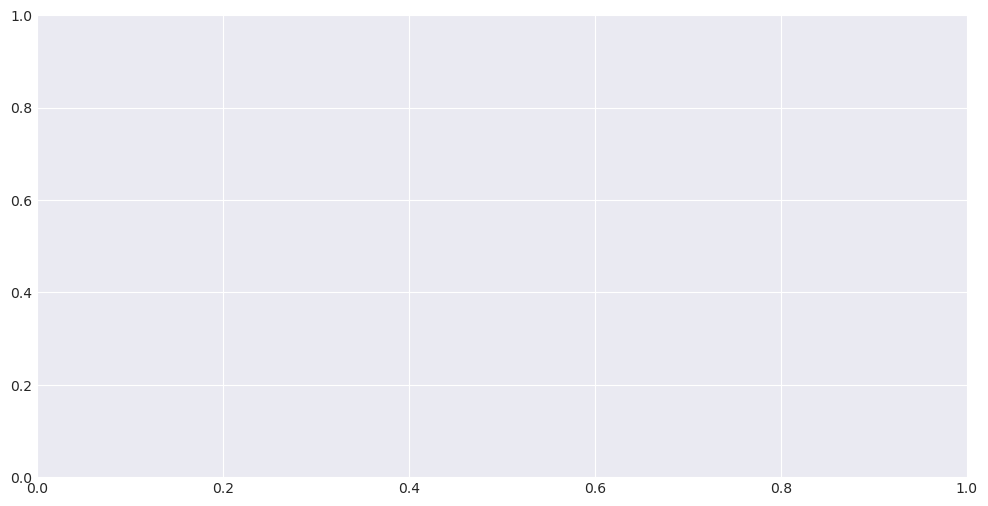

In [27]:
if has_compile_time:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Pivot compilation times - use config_name instead of config_label
    pivot_compile = build_metrics.pivot_table(index='config_name', columns='scheduler', values='compile_time')
    pivot_compile = pivot_compile[scheduler_order]

    x = np.arange(len(pivot_compile.index))
    width = 0.25

    for i, scheduler in enumerate(scheduler_order):
        offset = (i - 1) * width
        bars = ax.bar(x + offset, pivot_compile[scheduler], width, label=scheduler, alpha=0.8)
        
        # Add value labels on bars
        for j, (bar, val) in enumerate(zip(bars, pivot_compile[scheduler])):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.2f}s', ha='center', va='bottom', fontsize=8, rotation=0)

    ax.set_ylabel('Compilation Time (seconds)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Configuration', fontweight='bold', fontsize=12)
    ax.set_title('Compilation Time by Scheduler and Configuration', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_compile.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(images_dir / 'compilation_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Saved: compilation_time.png")
else:
    print("Compilation time data not available in build_metrics.csv")

## Runtime Performance

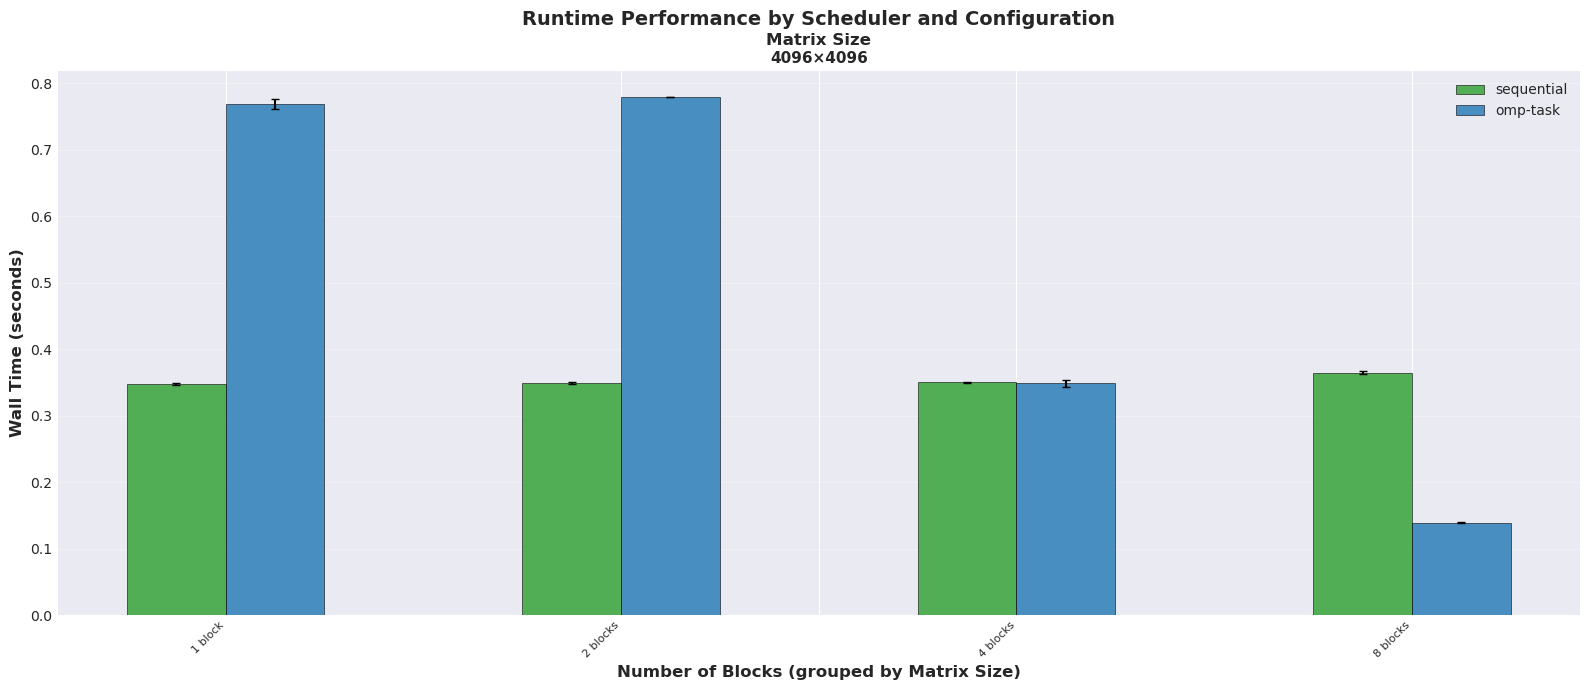

Saved: runtime_performance.png


In [ ]:
# Runtime Performance - Wall Time
# Bootstrap-based 95% CI error bars (percentile) instead of SE
# Sort by matrix_size first, then num_blocks
import numpy as _np

def bootstrap_ci(data, func=_np.mean, n_boot=1000, ci=95, random_state=0):
    """Compute bootstrap mean and two-sided percentile CI for an array-like.

    Returns: mean, se, (low, high)
    se is the bootstrap std of the resampled means (kept for reference).
    """
    arr = _np.asarray(data)
    if arr.size == 0:
        return _np.nan, _np.nan, (_np.nan, _np.nan)
    rng = _np.random.default_rng(random_state)
    boots = _np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        sample = rng.choice(arr, size=arr.size, replace=True)
        boots[i] = func(sample)
    mean = func(arr)
    se = boots.std(ddof=1)
    low = _np.percentile(boots, (100 - ci) / 2)
    high = _np.percentile(boots, 100 - (100 - ci) / 2)
    return mean, se, (low, high)

# Rebuild runtime_stats_sorted using bootstrap for mean and CI
runtime_rows = []
for (matrix_size, num_blocks, scheduler), group in results.groupby(['matrix_size', 'num_blocks', 'scheduler']):
    values = group['wall_time'].values
    mean, se, (low, high) = bootstrap_ci(values, func=_np.mean, n_boot=1000)
    runtime_rows.append({
        'matrix_size': matrix_size,
        'num_blocks': num_blocks,
        'scheduler': scheduler,
        'wall_time_mean': mean,
        'wall_time_se': se,
        'wall_time_ci_low': low,
        'wall_time_ci_high': high,
    })

runtime_stats_sorted = pd.DataFrame(runtime_rows)
if runtime_stats_sorted.empty:
    raise RuntimeError('No runtime data available to plot')

# Keep same sorting
runtime_stats_sorted = runtime_stats_sorted.sort_values(['matrix_size', 'num_blocks'])

# Pivot for plotting (means and CI endpoints)
pivot_wall = runtime_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='wall_time_mean')
pivot_wall_low = runtime_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='wall_time_ci_low')
pivot_wall_high = runtime_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='wall_time_ci_high')

# Use scheduler_order - only select columns that exist
available_schedulers = [s for s in scheduler_order if s in pivot_wall.columns]
pivot_wall = pivot_wall[available_schedulers]
# Fill missing CI endpoints with the mean (will make yerr=0)
pivot_wall_low = pivot_wall_low.reindex(columns=available_schedulers).fillna(pivot_wall)
pivot_wall_high = pivot_wall_high.reindex(columns=available_schedulers).fillna(pivot_wall)

# Calculate positions with spacing between matrix size groups
matrix_sizes_numeric = sorted(pivot_wall.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_wall.loc[matrix_size]
    group_start = current_x

    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1

    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += group_spacing

x_positions = np.array(x_positions)

# Flatten data for plotting
flat_wall = pivot_wall.values
flat_wall_low = pivot_wall_low.values
flat_wall_high = pivot_wall_high.values

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot bars with asymmetric CI error bars for each scheduler
for i, scheduler in enumerate(available_schedulers):
    # compute offset for grouped bars
    offset = (i - len(available_schedulers)//2) * width if len(available_schedulers) % 2 == 1 else (i - len(available_schedulers)/2 + 0.5) * width
    color = scheduler_colors.get(scheduler, f'C{i}')

    # compute asymmetric errors: lower = mean - low_ci, upper = high_ci - mean
    lower = flat_wall[:, i] - flat_wall_low[:, i]
    upper = flat_wall_high[:, i] - flat_wall[:, i]
    # ensure non-negative errors
    lower = _np.maximum(lower, 0)
    upper = _np.maximum(upper, 0)
    yerr = _np.vstack([lower, upper])

    bars = ax.bar(x_positions + offset, flat_wall[:, i], width,
                  yerr=yerr,
                  label=scheduler, color=color, alpha=0.8,
                  capsize=3, edgecolor='black', linewidth=0.5)

# Add vertical separators between matrix size groups
current_x = 0
for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    if matrix_idx > 0:
        separator_x = current_x - group_spacing / 2
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

    matrix_data = pivot_wall.loc[matrix_size]
    current_x += len(matrix_data) + group_spacing

ax.set_ylabel('Wall Time (seconds)', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
ax.set_title('Runtime Performance by Scheduler and Configuration', fontweight='bold', fontsize=14)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')

# Add matrix size labels as secondary x-axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(matrix_group_centers)
ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', which='both', length=0)

ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(images_dir / 'runtime_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: runtime_performance.png")

## Runtime Performance - Relative to Sequential (% Change)

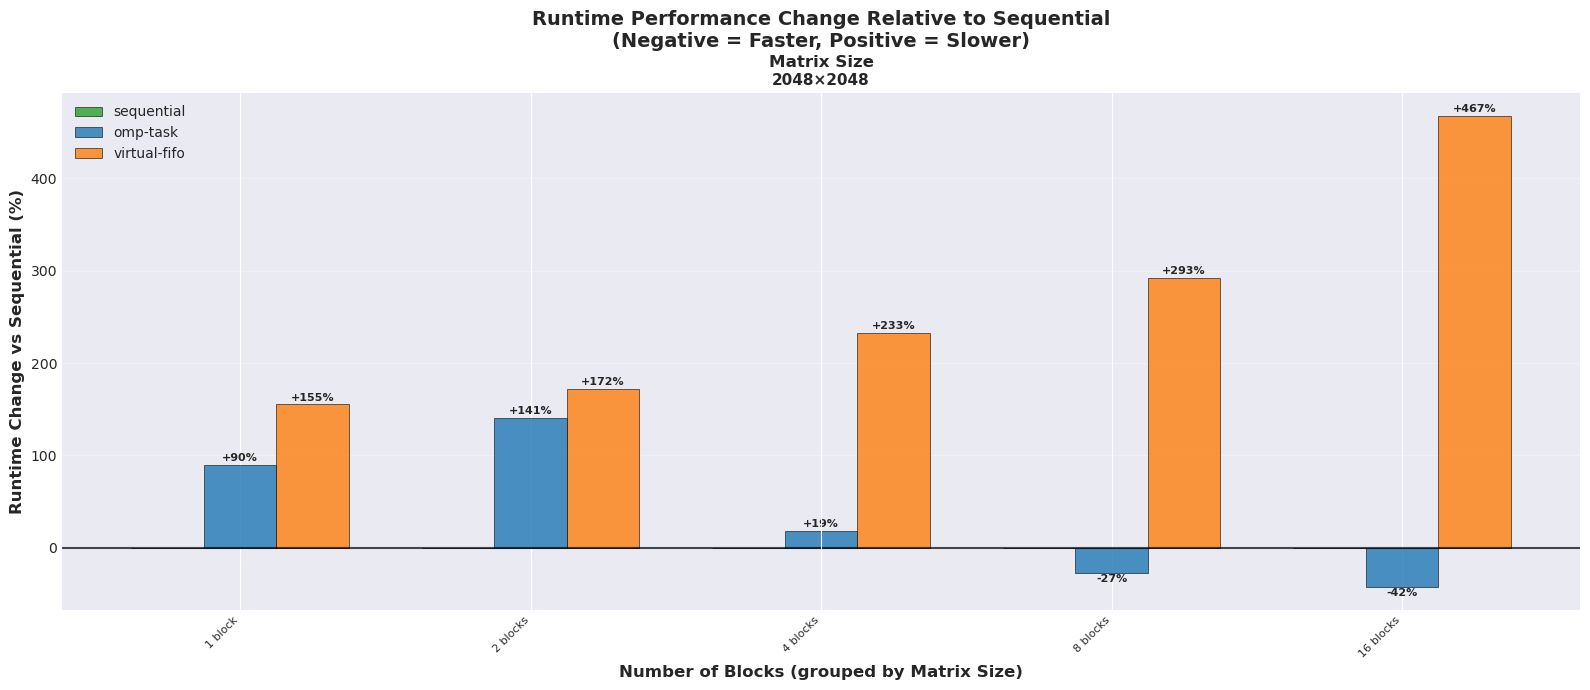

Saved: runtime_performance_relative.png


In [ ]:
# Runtime Performance - Percentage Change Relative to Sequential
# Calculate percentage change for each configuration
runtime_relative = runtime_stats_sorted.copy()

# For each matrix_size and num_blocks combination, calculate % change vs sequential
relative_data = []
for (matrix_size, num_blocks), group in runtime_relative.groupby(['matrix_size', 'num_blocks']):
    seq_data = group[group['scheduler'] == 'sequential']
    if len(seq_data) == 0:
        continue
    
    seq_time = seq_data['wall_time_mean'].values[0]
    
    for _, row in group.iterrows():
        pct_change = ((row['wall_time_mean'] - seq_time) / seq_time) * 100
        relative_data.append({
            'matrix_size': matrix_size,
            'num_blocks': num_blocks,
            'scheduler': row['scheduler'],
            'pct_change': pct_change,
            'seq_baseline': seq_time
        })

runtime_relative_df = pd.DataFrame(relative_data)
runtime_relative_df = runtime_relative_df.sort_values(['matrix_size', 'num_blocks'])

# Pivot for plotting
pivot_pct = runtime_relative_df.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='pct_change')
pivot_pct = pivot_pct[scheduler_order]

# Calculate positions (same as absolute graph)
matrix_sizes_numeric = sorted(pivot_pct.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_pct.loc[matrix_size]
    group_start = current_x
    
    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1
    
    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += group_spacing

x_positions = np.array(x_positions)

# Flatten data for plotting
flat_pct = pivot_pct.values

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot bars for each scheduler
for i, scheduler in enumerate(scheduler_order):
    offset = (i - 1) * width
    color = scheduler_colors.get(scheduler, f'C{i}')
    
    values = flat_pct[:, i]
    valid_mask = ~np.isnan(values)
    
    if valid_mask.any():
        valid_x = (x_positions + offset)[valid_mask]
        valid_values = values[valid_mask]
        
        bars = ax.bar(valid_x, valid_values, width,
                      label=scheduler, color=color, alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for xp, val in zip(valid_x, valid_values):
            if abs(val) > 0.5:  # Only show label if significant
                y_pos = val + (2 if val >= 0 else -2)
                va = 'bottom' if val >= 0 else 'top'
                ax.text(xp, y_pos, f'{val:+.0f}%', ha='center', va=va, fontsize=8, fontweight='bold')

# Add reference line at 0%
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)

# Add vertical separators between matrix size groups
current_x = 0
for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    if matrix_idx > 0:
        separator_x = current_x - group_spacing / 2
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    
    matrix_data = pivot_pct.loc[matrix_size]
    current_x += len(matrix_data) + group_spacing

ax.set_ylabel('Runtime Change vs Sequential (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
ax.set_title('Runtime Performance Change Relative to Sequential\n(Negative = Faster, Positive = Slower)', fontweight='bold', fontsize=14)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')

# Add matrix size labels as secondary x-axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(matrix_group_centers)
ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', which='both', length=0)

ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(images_dir / 'runtime_performance_relative.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: runtime_performance_relative.png")

## Memory Usage (Max RSS)

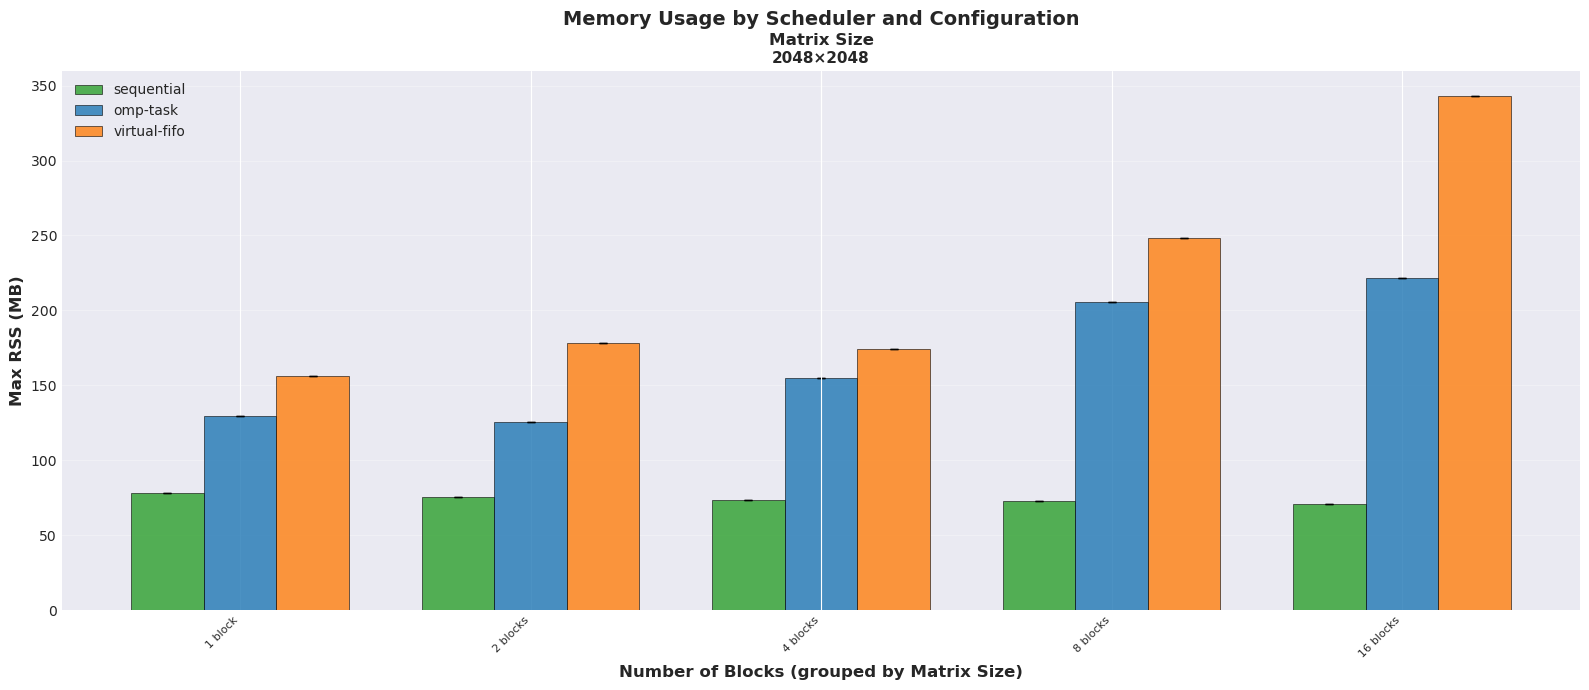

Saved: memory_usage.png


In [ ]:
# Memory Usage (Max RSS)
# Use bootstrap-derived 95% CI error bars (percentile)
import numpy as _np

# Reuse bootstrap_ci defined earlier (in runtime cell). If it's not available in the kernel
# (e.g., user restarts), define a fallback.
try:
    bootstrap_ci
except NameError:
    def bootstrap_ci(data, func=_np.mean, n_boot=1000, ci=95, random_state=0):
        arr = _np.asarray(data)
        if arr.size == 0:
            return _np.nan, _np.nan, (_np.nan, _np.nan)
        rng = _np.random.default_rng(random_state)
        boots = _np.empty(n_boot, dtype=float)
        for i in range(n_boot):
            sample = rng.choice(arr, size=arr.size, replace=True)
            boots[i] = func(sample)
        mean = func(arr)
        se = boots.std(ddof=1)
        low = _np.percentile(boots, 2.5)
        high = _np.percentile(boots, 97.5)
        return mean, se, (low, high)

# Build memory stats with bootstrap (means and CI endpoints)
memory_rows = []
for (matrix_size, num_blocks, scheduler), group in results.groupby(['matrix_size', 'num_blocks', 'scheduler']):
    values = group['max_rss_kb'].values
    mean, se, (low, high) = bootstrap_ci(values, func=_np.mean, n_boot=1000)
    memory_rows.append({
        'matrix_size': matrix_size,
        'num_blocks': num_blocks,
        'scheduler': scheduler,
        'max_rss_kb_mean': mean,
        'max_rss_kb_se': se,
        'max_rss_kb_ci_low': low,
        'max_rss_kb_ci_high': high,
    })

memory_stats_sorted = pd.DataFrame(memory_rows)
if memory_stats_sorted.empty:
    raise RuntimeError('No memory data available to plot')

memory_stats_sorted = memory_stats_sorted.sort_values(['matrix_size', 'num_blocks'])

# Pivot for plotting (convert to MB) - means and CI endpoints
pivot_rss = memory_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='max_rss_kb_mean') / 1024
pivot_rss_low = memory_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='max_rss_kb_ci_low') / 1024
pivot_rss_high = memory_stats_sorted.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='max_rss_kb_ci_high') / 1024

# Use scheduler_order
available_schedulers = [s for s in scheduler_order if s in pivot_rss.columns]
pivot_rss = pivot_rss[available_schedulers]
# Fill missing CI endpoints with mean so yerr becomes zero
pivot_rss_low = pivot_rss_low.reindex(columns=available_schedulers).fillna(pivot_rss)
pivot_rss_high = pivot_rss_high.reindex(columns=available_schedulers).fillna(pivot_rss)

# Calculate positions (reuse same structure as runtime)
matrix_sizes_numeric = sorted(pivot_rss.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_rss.loc[matrix_size]
    group_start = current_x

    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1

    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += group_spacing

x_positions = np.array(x_positions)

# Flatten data for plotting
flat_rss = pivot_rss.values
flat_rss_low = pivot_rss_low.values
flat_rss_high = pivot_rss_high.values

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot bars with asymmetric CI error bars for each scheduler
for i, scheduler in enumerate(available_schedulers):
    offset = (i - len(available_schedulers)//2) * width if len(available_schedulers) % 2 == 1 else (i - len(available_schedulers)/2 + 0.5) * width
    color = scheduler_colors.get(scheduler, f'C{i}')

    lower = flat_rss[:, i] - flat_rss_low[:, i]
    upper = flat_rss_high[:, i] - flat_rss[:, i]
    lower = _np.maximum(lower, 0)
    upper = _np.maximum(upper, 0)
    yerr = _np.vstack([lower, upper])

    bars = ax.bar(x_positions + offset, flat_rss[:, i], width,
                  yerr=yerr,
                  label=scheduler, color=color, alpha=0.8,
                  capsize=3, edgecolor='black', linewidth=0.5)

# Add vertical separators between matrix size groups
current_x = 0
for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    if matrix_idx > 0:
        separator_x = current_x - group_spacing / 2
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

    matrix_data = pivot_rss.loc[matrix_size]
    current_x += len(matrix_data) + group_spacing

ax.set_ylabel('Max RSS (MB)', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
ax.set_title('Memory Usage by Scheduler and Configuration', fontweight='bold', fontsize=14)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')

# Add matrix size labels as secondary x-axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(matrix_group_centers)
ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', which='both', length=0)

ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(images_dir / 'memory_usage.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: memory_usage.png")

## Memory Usage - Relative to Sequential (% Change)

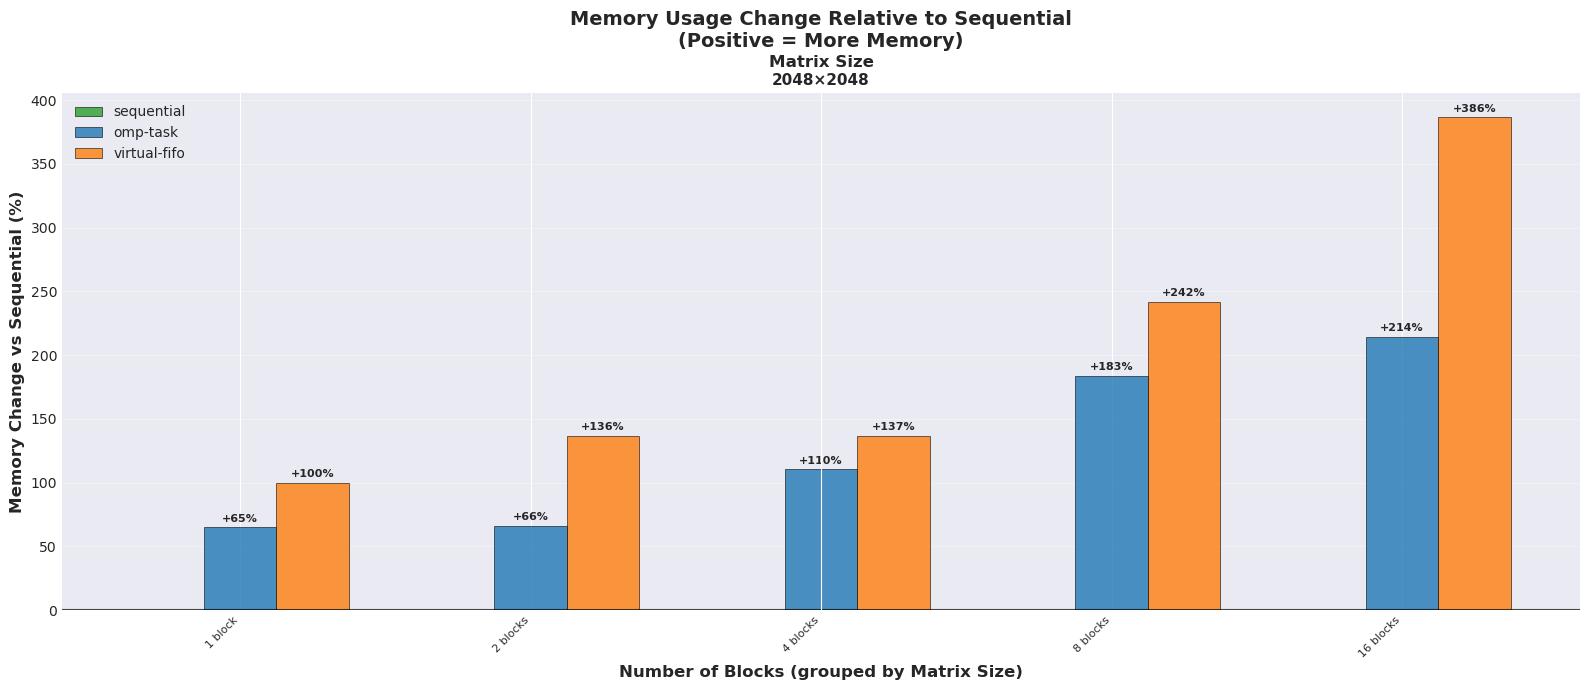

Saved: memory_usage_relative.png


In [ ]:
# Memory Usage - Percentage Change Relative to Sequential
# Calculate percentage change for each configuration
memory_relative = memory_stats_sorted.copy()

# For each matrix_size and num_blocks combination, calculate % change vs sequential
relative_data = []
for (matrix_size, num_blocks), group in memory_relative.groupby(['matrix_size', 'num_blocks']):
    seq_data = group[group['scheduler'] == 'sequential']
    if len(seq_data) == 0:
        continue
    
    seq_memory = seq_data['max_rss_kb_mean'].values[0]
    
    for _, row in group.iterrows():
        pct_change = ((row['max_rss_kb_mean'] - seq_memory) / seq_memory) * 100
        relative_data.append({
            'matrix_size': matrix_size,
            'num_blocks': num_blocks,
            'scheduler': row['scheduler'],
            'pct_change': pct_change,
            'seq_baseline': seq_memory
        })

memory_relative_df = pd.DataFrame(relative_data)
memory_relative_df = memory_relative_df.sort_values(['matrix_size', 'num_blocks'])

# Pivot for plotting
pivot_pct = memory_relative_df.pivot_table(
    index=['matrix_size', 'num_blocks'], columns='scheduler', values='pct_change')
pivot_pct = pivot_pct[scheduler_order]

# Calculate positions (same as absolute graph)
matrix_sizes_numeric = sorted(pivot_pct.index.get_level_values(0).unique())
x_positions = []
tick_positions = []
tick_labels = []
matrix_group_centers = []

current_x = 0
width = 0.25
group_spacing = 0.5

for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    matrix_data = pivot_pct.loc[matrix_size]
    group_start = current_x
    
    for config_idx, num_blocks in enumerate(matrix_data.index):
        x_positions.append(current_x)
        tick_positions.append(current_x)
        tick_labels.append(f"{num_blocks} block{'s' if num_blocks > 1 else ''}")
        current_x += 1
    
    group_end = current_x - 1
    matrix_group_centers.append((group_start + group_end) / 2)
    current_x += group_spacing

x_positions = np.array(x_positions)

# Flatten data for plotting
flat_pct = pivot_pct.values

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot bars for each scheduler
for i, scheduler in enumerate(scheduler_order):
    offset = (i - 1) * width
    color = scheduler_colors.get(scheduler, f'C{i}')
    
    values = flat_pct[:, i]
    valid_mask = ~np.isnan(values)
    
    if valid_mask.any():
        valid_x = (x_positions + offset)[valid_mask]
        valid_values = values[valid_mask]
        
        bars = ax.bar(valid_x, valid_values, width,
                      label=scheduler, color=color, alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for xp, val in zip(valid_x, valid_values):
            if abs(val) > 1:  # Only show label if significant
                y_pos = val + (3 if val >= 0 else -3)
                va = 'bottom' if val >= 0 else 'top'
                ax.text(xp, y_pos, f'{val:+.0f}%', ha='center', va=va, fontsize=8, fontweight='bold')

# Add reference line at 0%
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)

# Add vertical separators between matrix size groups
current_x = 0
for matrix_idx, matrix_size in enumerate(matrix_sizes_numeric):
    if matrix_idx > 0:
        separator_x = current_x - group_spacing / 2
        ax.axvline(x=separator_x, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    
    matrix_data = pivot_pct.loc[matrix_size]
    current_x += len(matrix_data) + group_spacing

ax.set_ylabel('Memory Change vs Sequential (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Number of Blocks (grouped by Matrix Size)', fontweight='bold', fontsize=12)
ax.set_title('Memory Usage Change Relative to Sequential\n(Positive = More Memory)', fontweight='bold', fontsize=14)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=8, rotation=45, ha='right')

# Add matrix size labels as secondary x-axis
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(matrix_group_centers)
ax2.set_xticklabels([f'{ms}×{ms}' for ms in matrix_sizes_numeric], fontweight='bold', fontsize=11)
ax2.set_xlabel('Matrix Size', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', which='both', length=0)

ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(images_dir / 'memory_usage_relative.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: memory_usage_relative.png")

## Summary Statistics

In [ ]:
print("=" * 80)
print("BINARY SIZE SUMMARY (KB)")
print("=" * 80)

# Build aggregation dict based on available columns
agg_dict = {
    'total_size': ['mean', 'min', 'max'],
    'text_size': ['mean', 'min', 'max']
}
if has_compile_time:
    agg_dict['compile_time'] = ['mean', 'min', 'max']

summary = build_metrics.groupby('scheduler').agg(agg_dict) / 1024
if has_compile_time:
    summary['compile_time'] *= 1024  # Don't convert compile time
print(summary.round(2))

print("\n" + "=" * 80)
print("RUNTIME PERFORMANCE SUMMARY")
print("=" * 80)
perf_summary = results.groupby('scheduler').agg({
    'wall_time': ['mean', 'std', 'min', 'max'],
    'max_rss_kb': ['mean', 'std', 'min', 'max']
})
print(perf_summary.round(4))

print("\n" + "=" * 80)
print("OVERHEAD ANALYSIS (vs sequential)")
print("=" * 80)
seq_size = build_metrics[build_metrics['scheduler'] == 'sequential']['total_size'].mean()
for scheduler in ['omp-task', 'virtual-fifo']:
    sched_size = build_metrics[build_metrics['scheduler'] == scheduler]['total_size'].mean()
    overhead = ((sched_size / seq_size) - 1) * 100
    print(f"{scheduler:20s} binary size overhead: {overhead:6.1f}% ({sched_size/1024:.1f} KB vs {seq_size/1024:.1f} KB)")

if has_compile_time:
    print()
    seq_compile = build_metrics[build_metrics['scheduler'] == 'sequential']['compile_time'].mean()
    for scheduler in ['omp-task', 'virtual-fifo']:
        sched_compile = build_metrics[build_metrics['scheduler'] == scheduler]['compile_time'].mean()
        overhead = ((sched_compile / seq_compile) - 1) * 100
        print(f"{scheduler:20s} compile time overhead: {overhead:6.1f}% ({sched_compile:.2f}s vs {seq_compile:.2f}s)")
else:
    print("\nCompilation time overhead analysis not available (no compile_time data)")

BINARY SIZE SUMMARY (KB)
             total_size                 text_size              compile_time  \
                   mean    min      max      mean   min    max         mean   
scheduler                                                                     
omp-task           9.56   8.48    10.02      2.10  1.22   2.49         0.30   
sequential         8.47   7.84     8.74      1.41  0.99   1.61         0.30   
virtual-fifo     823.51  20.75  3442.86     28.80  9.09  91.87        10.84   

                           
               min    max  
scheduler                  
omp-task      0.08   0.64  
sequential    0.09   0.64  
virtual-fifo  0.12  48.26  

RUNTIME PERFORMANCE SUMMARY
             wall_time                         max_rss_kb                      \
                  mean     std     min     max       mean         std     min   
scheduler                                                                       
omp-task        0.0752  0.0436  0.0293  0.1308   171313.6  4


Analyzing: instances/2048_1_sequential/build/test/Iara/05-cholesky/build-sequential/a.out
instances/2048_1_sequential/build/test/Iara/05-cholesky/build-sequential/a.out  :
section                 size    addr
.interp                   28     736
.note.gnu.property        32     768
.note.ABI-tag             32     800
.gnu.hash                 28     832
.dynsym                  576     864
.dynstr                  577    1440
.gnu.version              48    2018
.gnu.version_r            96    2068
.rela.dyn                168    2168
.rela.plt                192    2336
.eh_frame                 48    2528
.eh_frame_hdr             20    2576
.rodata                    9    2596
.rodata.cst16             16    2608
.rodata.cst8              16    2624
.rodata.str1.1           306    2640
.fini                     13    7044
.init                     27    7060
.plt                     160    7088
.plt.got                   8    7248
.text                   1015    7264
.data.rel.ro 

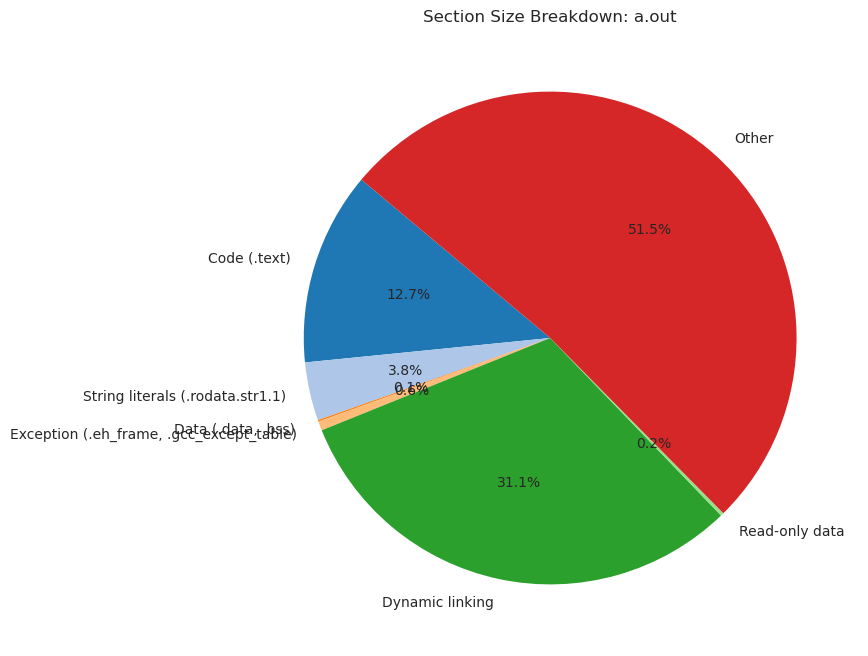


Analyzing: instances/2048_1_omp-task/build/test/Iara/05-cholesky/build-omp-task/a.out
instances/2048_1_omp-task/build/test/Iara/05-cholesky/build-omp-task/a.out  :
section                 size    addr
.interp                   28     736
.note.gnu.property        32     768
.note.ABI-tag             32     800
.gnu.hash                 28     832
.dynsym                  576     864
.dynstr                  577    1440
.gnu.version              48    2018
.gnu.version_r            96    2068
.rela.dyn                216    2168
.rela.plt                336    2384
.eh_frame                 48    2720
.eh_frame_hdr             20    2768
.rodata                    9    2788
.rodata.cst16             16    2800
.rodata.cst8              16    2816
.rodata.str1.1           327    2832
.fini                     13    7256
.init                     27    7272
.plt                     256    7312
.plt.got                   8    7568
.text                   1246    7584
.data.rel.ro         

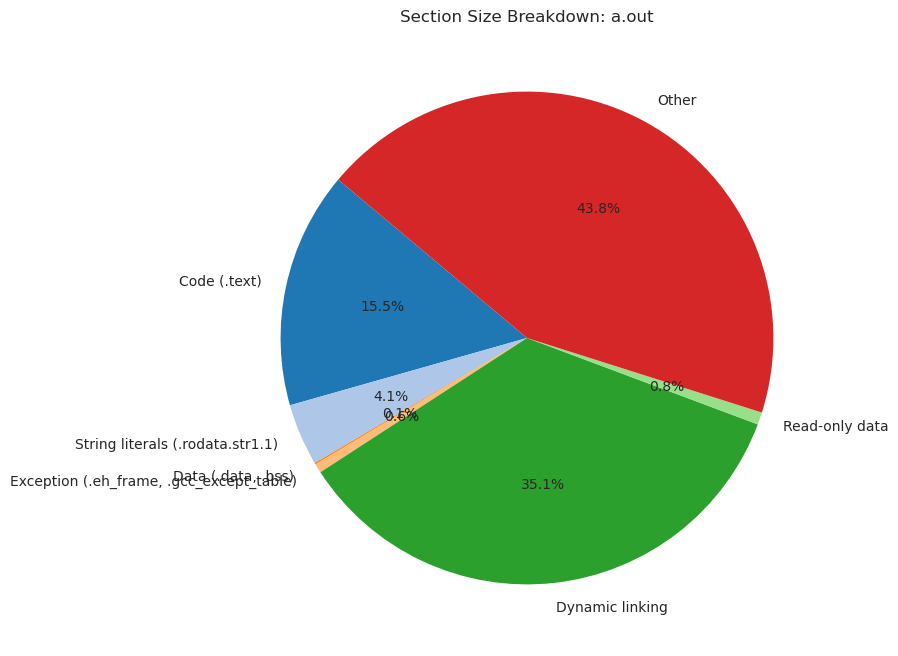


Analyzing: instances/2048_1_virtual-fifo/build/test/Iara/05-cholesky/build-virtual-fifo/a.out
instances/2048_1_virtual-fifo/build/test/Iara/05-cholesky/build-virtual-fifo/a.out  :
section                  size    addr
.interp                    28     736
.note.gnu.property         32     768
.note.ABI-tag              32     800
.gnu.hash                  28     832
.dynsym                   888     864
.dynstr                   864    1752
.gnu.version               74    2616
.gnu.version_r            176    2692
.rela.dyn                1416    2872
.rela.plt                 648    4288
.eh_frame                 112    4936
.eh_frame_hdr              44    5048
.rodata                   419    5104
.rodata.cst16              64    5536
.rodata.cst8               16    5600
.rodata.str1.1            332    5616
.fini                      13   10044
.init                      27   10060
.plt                      464   10096
.plt.got                    8   10560
.text                

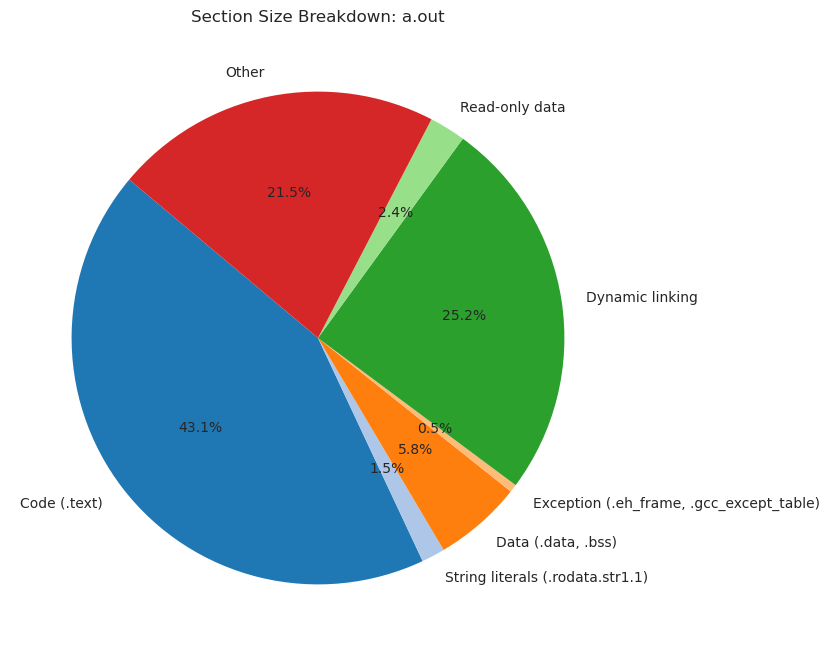

In [ ]:
# Visualize section size breakdown for experiment binaries (dynamic, from actual binaries)
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re
from pathlib import Path

exec_path = "build/test/Iara/05-cholesky"

schedulers = ["sequential", "omp-task", "virtual-fifo"]

# List of binaries to analyze (update paths as needed)
binary_paths = [Path(f"./instances/2048_1_{scheduler}/{exec_path}/build-{scheduler}/a.out") for scheduler in schedulers]

def get_section_sizes(binary_path):
    """Run 'size -A' and parse section sizes for a binary."""
    try:
        result = subprocess.run(['size', '-A', str(binary_path)], capture_output=True, text=True, check=True)
        print(result.stdout)
        lines = result.stdout.splitlines()
        section_sizes = {}
        for line in lines:
            m = re.match(r'\s*(\S+)\s+(\d+)', line)
            if m:
                section = m.group(1)
                size = int(m.group(2))
                section_sizes[section] = size
        return section_sizes
    except Exception as e:
        print(f"Error reading {binary_path}: {e}")
        return {}

# Section groups for visualization
groups = {
    'Code (.text)': ['.text'],
    'String literals (.rodata.str1.1)': ['.rodata.str1.1'],
    'Data (.data, .bss)': ['.data', '.bss'],
    'Exception (.eh_frame, .gcc_except_table)': ['.eh_frame', '.gcc_except_table'],
    'Dynamic linking': ['.dynamic', '.plt', '.got.plt', '.dynsym', '.dynstr', '.gnu.version', '.gnu.version_r', '.rela.dyn', '.rela.plt', '.eh_frame_hdr'],
    'Read-only data': ['.rodata', '.data.rel.ro'],
    'Other': ['.comment', '.interp', '.note.gnu.property', '.note.ABI-tag', '.gnu.hash', '.fini', '.init', '.plt.got', '.fini_array', '.init_array', '.got', '.relro_padding', '.tm_clone_table', '.gnu.build.attributes', '.annobin.notes']
}

for binary_path in binary_paths:
    print(f"\nAnalyzing: {binary_path}")
    section_sizes = get_section_sizes(binary_path)
    if not section_sizes:
        print("No section info found.")
        continue
    # Group sizes
    group_sizes = {}
    for group, keys in groups.items():
        group_sizes[group] = sum(section_sizes.get(k, 0) for k in keys)
    # Pie chart
    labels = list(group_sizes.keys())
    sizes = list(group_sizes.values())
    colors = plt.cm.tab20.colors[:len(labels)]
    plt.figure(figsize=(8,8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Section Size Breakdown: {binary_path.name}')
    plt.show()

---
**Note on Binary Compilation for Experiments**
- All experiment binaries are now compiled with the following flags in Release mode:
    - `-fvisibility=hidden`: Hides non-exported symbols to reduce symbol/function/class names in the binary.
    - `-fno-rtti`: Disables C++ runtime type information.
    - `-fno-exceptions`: Disables exception handling.
    - `strip`: Removes symbol tables after build.
- These changes minimize the presence of debug/function/class names and reduce binary size for more accurate experiment results.
- See the main `CMakeLists.txt` for implementation details.